In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [13]:
# Load the CSV
df = pd.read_csv("/kaggle/input/age-gender-csv/age_gender.csv")
df.head()


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


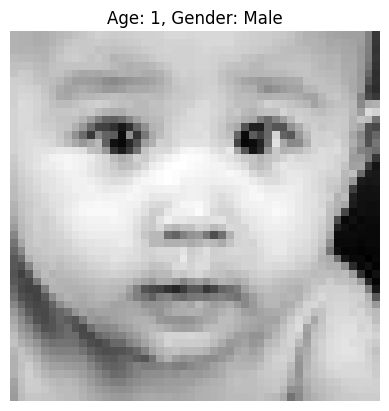

In [14]:
# View one sample as image
pixels = np.array([int(p) for p in df['pixels'][0].split()], dtype=np.uint8).reshape(48, 48)
plt.imshow(pixels, cmap='gray')
plt.title(f"Age: {df['age'][0]}, Gender: {'Male' if df['gender'][0]==0 else 'Female'}")
plt.axis('off')
plt.show()


In [15]:
# Convert pixels to image array
def process_pixels(pixel_str):
    pixels = np.array([int(p) for p in pixel_str.split()], dtype=np.uint8)
    return pixels.reshape(48, 48, 1)

X = np.array([process_pixels(pix) for pix in df['pixels']])
X = X / 255.0  # Normalize

# Prepare labels
y_age = df['age'].values
y_gender = to_categorical(df['gender'].values, 2)


In [16]:
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    X, y_age, y_gender, test_size=0.2, random_state=42
)


In [17]:
input_layer = Input(shape=(48, 48, 1))

x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)

# Output for Age (regression)
age_output = Dense(1, name='age_output')(x)

# Output for Gender (classification)
gender_output = Dense(2, activation='softmax', name='gender_output')(x)

model = Model(inputs=input_layer, outputs=[age_output, gender_output])


In [18]:
model.compile(
    optimizer='adam',
    loss={'age_output': 'mse', 'gender_output': 'categorical_crossentropy'},
    metrics={'age_output': 'mae', 'gender_output': 'accuracy'}
)


In [19]:
history = model.fit(
    X_train,
    {'age_output': y_age_train, 'gender_output': y_gender_train},
    validation_data=(X_test, {'age_output': y_age_test, 'gender_output': y_gender_test}),
    epochs=10,
    batch_size=64
)
model.save('age_gender_model.h5')

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step - age_output_loss: 624.9348 - age_output_mae: 19.1542 - gender_output_accuracy: 0.5777 - gender_output_loss: 0.7101 - loss: 625.6465 - val_age_output_loss: 331.4856 - val_age_output_mae: 13.8869 - val_gender_output_accuracy: 0.7030 - val_gender_output_loss: 0.5948 - val_loss: 331.3983
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 24s 82ms/step - age_output_loss: 308.9274 - age_output_mae: 13.5060 - gender_output_accuracy: 0.7021 - gender_output_loss: 0.6253 - loss: 309.5535 - val_age_output_loss: 241.9082 - val_age_output_mae: 12.1753 - val_gender_output_accuracy: 0.7583 - val_gender_output_loss: 0.5403 - val_loss: 242.2881
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 24s 82ms/step - age_output_loss: 263.2468 - age_output_mae: 12.5758 - gender_output_accuracy: 0.7435 - gender_output_loss: 0.5639 - loss: 263.8095 - val_age_output_loss: 223.2188 - val_age_output_mae: 11.5921 - val_gender_output_accuracy: 0.7927 - val_gender_output_loss: 0.4446 -

In [20]:
results = model.evaluate(
    X_test,
    {'age_output': y_age_test, 'gender_output': y_gender_test}
)
print(f"Test Loss: {results[0]}")
print(f"Age MAE: {results[3]}")
print(f"Gender Accuracy: {results[4]}")


149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - age_output_loss: 190.4501 - age_output_mae: 10.3822 - gender_output_accuracy: 0.7479 - gender_output_loss: 0.5601 - loss: 191.0154
Test Loss: 193.9940643310547
Age MAE: 10.50826358795166
Gender Accuracy: 0.7336004972457886


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


/tmp/ipykernel_31/2446834640.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Actual Age: {y_age_test[i]}, Predicted Age: {int(pred_age[i])}\n"


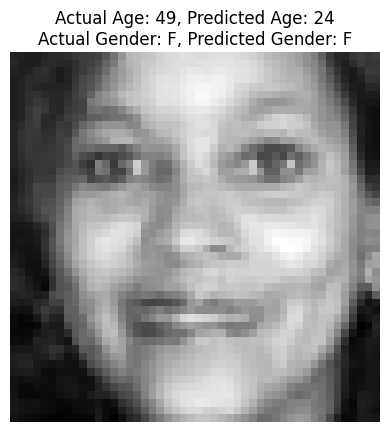

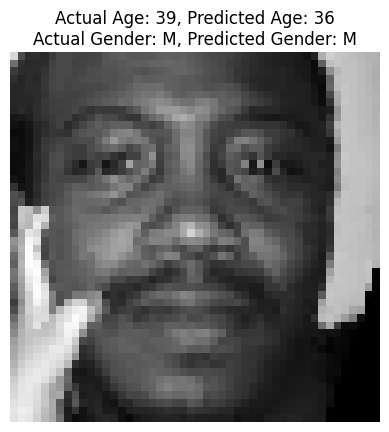

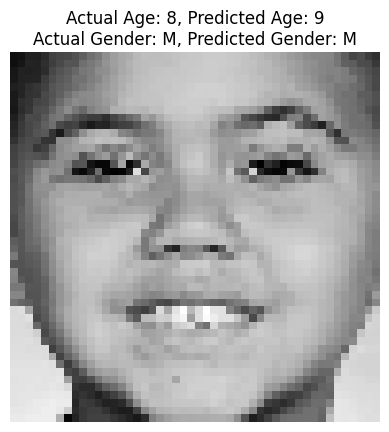

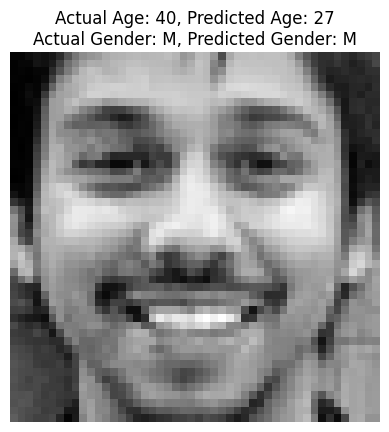

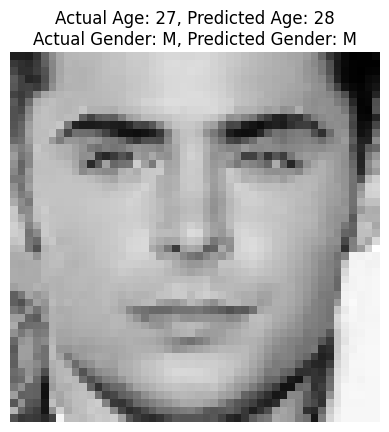

In [21]:
pred_age, pred_gender = model.predict(X_test[:5])
for i in range(5):
    plt.imshow(X_test[i].reshape(48, 48), cmap='gray')
    plt.title(f"Actual Age: {y_age_test[i]}, Predicted Age: {int(pred_age[i])}\n"
              f"Actual Gender: {'M' if np.argmax(y_gender_test[i])==0 else 'F'}, "
              f"Predicted Gender: {'M' if np.argmax(pred_gender[i])==0 else 'F'}")
    plt.axis('off')
    plt.show()
